# Cargue y Preentrenamiento de los datos

In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path)
                    imagenes.append(np.array(img)) 
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

def obtener_tamanios_por_etiqueta(imagenes, etiquetas):
    tamanios_por_etiqueta = {}
    for img, etiqueta in zip(imagenes, etiquetas):
        tamanio = img.shape[:2]
        if etiqueta not in tamanios_por_etiqueta:
            tamanios_por_etiqueta[etiqueta] = set()
        tamanios_por_etiqueta[etiqueta].add(tamanio)
    return tamanios_por_etiqueta

def redimensionar_imagenes(imagenes, nuevo_tamanio):
    imagenes_redimensionadas = []
    for img in imagenes:
        img_pil = Image.fromarray(img)
        img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)
        imagenes_redimensionadas.append(np.array(img_redimensionada))
    return imagenes_redimensionadas

def verificar_tamanio(imagenes):
    tamanio_referencia = None
    for img in imagenes:
        if tamanio_referencia is None:
            tamanio_referencia = img.shape[:2]
        else:
            if img.shape[:2] != tamanio_referencia:
                return False
    return True

def normalizar_imagenes(imagenes):
    imagenes_array = np.array(imagenes)
    imagenes_normalizadas = imagenes_array / 255.0
    media = np.mean(imagenes_normalizadas, axis=(0, 1, 2))
    imagenes_normalizadas -= media
    return imagenes_normalizadas


In [2]:
# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/WHU'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Obtener tamaños por etiqueta antes de redimensionar
tamanios_por_etiqueta = obtener_tamanios_por_etiqueta(imagenes, etiquetas)

tamanios_por_etiqueta


{'baseballdiamond': {(253, 256),
  (255, 256),
  (256, 250),
  (256, 252),
  (256, 256)},
 'footballField': {(600, 600)},
 'golfcourse': {(251, 256), (256, 256)},
 'Park': {(600, 600)},
 'Pond': {(600, 600)},
 'tenniscourt': {(256, 247), (256, 255), (256, 256)}}

In [3]:
nuevo_tamanio = (256, 256)
imagenes_redimensionadas = redimensionar_imagenes(imagenes, nuevo_tamanio)

if verificar_tamanio(imagenes_redimensionadas):
    print("Todas las imágenes tienen el mismo tamaño.")
else:
    print("Las imágenes tienen diferentes tamaños.")
    
imagenes_normalizadas = normalizar_imagenes(imagenes_redimensionadas)

C:\Users\nicol\AppData\Local\Temp\ipykernel_10228\279961940.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)


Todas las imágenes tienen el mismo tamaño.


In [4]:
# Codificar las etiquetas
codificacion = {'baseballdiamond': 0, 'footballField': 1, 'golfcourse': 2, 'Park': 3, 'Pond': 4, 'tenniscourt': 5}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42)

# Aplanar las imágenes para el sobremuestreo
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, -1))

# Mostrar la distribución de clases antes del balanceo
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento antes del balanceo:")
print(dict(zip(unique, counts)))


Distribución de clases en el conjunto de entrenamiento antes del balanceo:
{0: 74, 1: 42, 2: 83, 3: 39, 4: 46, 5: 79}


In [5]:
# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original
X_train_res = X_train_res_2d.reshape((-1, height, width, channels))

# Mostrar la distribución de clases después del balanceo
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento después del balanceo:")
print(dict(zip(unique_res, counts_res)))



Distribución de clases en el conjunto de entrenamiento después del balanceo:
{0: 83, 1: 83, 2: 83, 3: 83, 4: 83, 5: 83}


In [6]:
# Imprimir el tamaño de los conjuntos de entrenamiento y prueba
print("Número de ejemplos de entrenamiento antes del balanceo:", len(X_train))
print("Número de ejemplos de entrenamiento después del balanceo:", len(X_train_res))
print("Número de ejemplos de prueba:", len(X_test))

Número de ejemplos de entrenamiento antes del balanceo: 363
Número de ejemplos de entrenamiento después del balanceo: 498
Número de ejemplos de prueba: 91


# Entrenamiento modelo customizado

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Crear un modelo secuencial
modelo = Sequential()

# Agregar una capa convolucional
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))

# Agregar una capa de agrupación
modelo.add(MaxPooling2D((2, 2)))

# Agregar otra capa convolucional
modelo.add(Conv2D(64, (3, 3), activation='relu'))

# Agregar otra capa de agrupación
modelo.add(MaxPooling2D((2, 2)))

# Agregar una capa de aplanamiento
modelo.add(Flatten())

# Agregar una capa totalmente conectada
modelo.add(Dense(64, activation='relu'))

# Agregar la capa de salida
modelo.add(Dense(6, activation='softmax'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
modelo.summary()


c:\Users\nicol\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,870 (60.14 MB)

 Trainable params: 15,764,870 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Entrenar el modelo
historial_entrenamiento = modelo.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_train_res, y_train_res))

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 936ms/step - accuracy: 0.3029 - loss: 3.1587 - val_accuracy: 0.6305 - val_loss: 1.2018
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 844ms/step - accuracy: 0.6348 - loss: 1.0444 - val_accuracy: 0.7651 - val_loss: 0.6533
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 856ms/step - accuracy: 0.7863 - loss: 0.5263 - val_accuracy: 0.9337 - val_loss: 0.2732
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 848ms/step - accuracy: 0.9280 - loss: 0.2478 - val_accuracy: 0.9458 - val_loss: 0.1935
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 846ms/step - accuracy: 0.9692 - loss: 0.1375 - val_accuracy: 0.9880 - val_loss: 0.0727
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 839ms/step - accuracy: 0.9837 - loss: 0.1012 - val_accuracy: 0.9859 - val_loss: 0.0589
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 849ms/step - accuracy: 0.9874 - loss: 0.0593 - val_accuracy: 0.9960 - val_loss: 0.0289
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 831ms/step - accuracy: 0.9990 - loss: 0.0281 - val_accu

In [9]:
resultados_evaluacion = modelo.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.7706 - loss: 0.8465


In [10]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Predecir las etiquetas para el conjunto de prueba
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular la precisión, recall, f1 score y accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['baseballdiamond', 'footballField', 'golfcourse', 'Park', 'Pond', 'tenniscourt']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step
Precision: 0.8397227772227773
Recall: 0.7912087912087912
F1 Score: 0.7979987394828847
Accuracy: 0.7912087912087912
Classification Report:
                 precision    recall  f1-score   support

baseballdiamond       1.00      0.77      0.87        26
  footballField       1.00      0.75      0.86         8
     golfcourse       0.69      0.65      0.67        17
           Park       1.00      0.73      0.84        11
           Pond       0.88      0.88      0.88         8
    tenniscourt       0.61      0.95      0.74        21

       accuracy                           0.79        91
      macro avg       0.86      0.79      0.81        91
   weighted avg       0.84      0.79      0.80        91



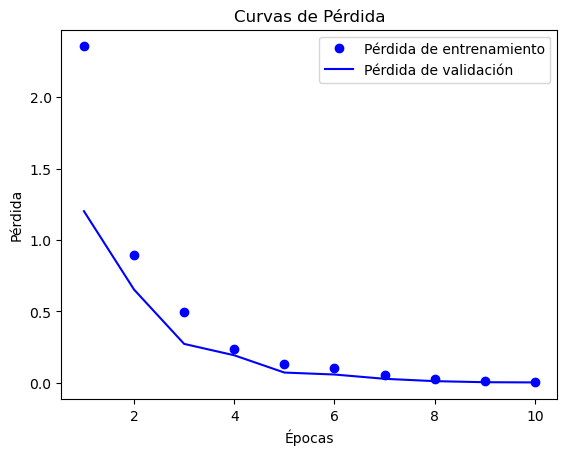

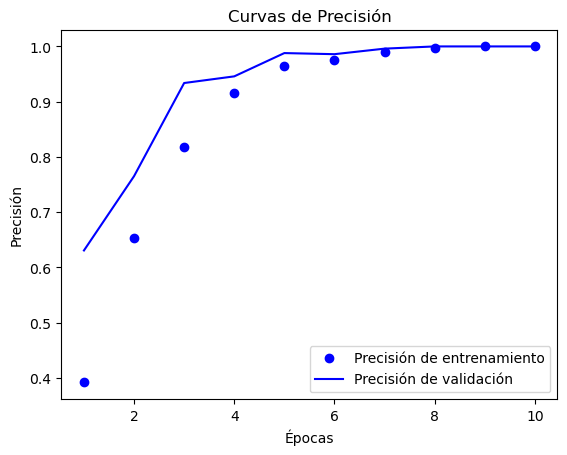

In [11]:
import matplotlib.pyplot as plt

# Obtener la pérdida y la precisión del historial de entrenamiento
pérdida = historial_entrenamiento.history['loss']
precisión = historial_entrenamiento.history['accuracy']
val_pérdida = historial_entrenamiento.history['val_loss']
val_precisión = historial_entrenamiento.history['val_accuracy']

# Visualizar las curvas de pérdida y precisión
épocas = range(1, len(pérdida) + 1)
plt.plot(épocas, pérdida, 'bo', label='Pérdida de entrenamiento')
plt.plot(épocas, val_pérdida, 'b', label='Pérdida de validación')
plt.title('Curvas de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(épocas, precisión, 'bo', label='Precisión de entrenamiento')
plt.plot(épocas, val_precisión, 'b', label='Precisión de validación')
plt.title('Curvas de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


In [12]:
# Abrir la imagen
#imagen = Image.open('C:/Users/nicol/Desktop/Datasets/Dota2/part2-001/images/P1105.png')

# Redimensionar la imagen a 256x256
#imagen_redimensionada = imagen.resize((256, 256))

# Convertir la imagen redimensionada a un arreglo (matriz) y normalizarla
#imagen_arreglo = np.array(imagen_redimensionada) / 255.0

# Agregar una dimensión adicional para representar el lote
#imagen_arreglo = np.expand_dims(imagen_arreglo, axis=0)

In [13]:
# Realizar predicciones
#predicciones = modelo.predict(imagen_arreglo)

# Interpretar las predicciones
#clase_predicha = np.argmax(predicciones, axis=1)

# Visualizar resultados (opcional)
#print("Predicciones:", clase_predicha)


# Entrenamiento con VGG16

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Cargar el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)  



In [15]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 129s 8s/step - accuracy: 0.3951 - loss: 3.0276 - val_accuracy: 0.8352 - val_loss: 0.6426
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - accuracy: 0.8186 - loss: 0.4909 - val_accuracy: 0.9011 - val_loss: 0.3736
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 126s 8s/step - accuracy: 0.8943 - loss: 0.3011 - val_accuracy: 0.9011 - val_loss: 0.3052
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 126s 8s/step - accuracy: 0.9295 - loss: 0.1823 - val_accuracy: 0.9341 - val_loss: 0.3142
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - accuracy: 0.9525 - loss: 0.1362 - val_accuracy: 0.9231 - val_loss: 0.2780
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - accuracy: 0.9456 - loss: 0.1411 - val_accuracy: 0.9231 - val_loss: 0.3545
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - accuracy: 0.9666 - loss: 0.0983 - val_accuracy: 0.9231 - val_loss: 0.3211
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - accuracy: 0.9709 - loss: 0.1030 - val_accuracy: 0.9231 - va

In [16]:

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['baseballdiamond', 'footballField', 'golfcourse', 'Park', 'Pond', 'tenniscourt']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Precision: 0.9422261658286504
Recall: 0.9340659340659341
F1 Score: 0.9346249693433495
Accuracy: 0.9340659340659341
Classification Report:
                 precision    recall  f1-score   support

baseballdiamond       0.96      0.85      0.90        26
  footballField       0.89      1.00      0.94         8
     golfcourse       0.81      1.00      0.89        17
           Park       1.00      0.91      0.95        11
           Pond       1.00      1.00      1.00         8
    tenniscourt       1.00      0.95      0.98        21

       accuracy                           0.93        91
      macro avg       0.94      0.95      0.94        91
   weighted avg       0.94      0.93      0.93        91



# Entrenamiento con Resnet50

In [17]:
from tensorflow.keras.applications import ResNet50

# Cargar el modelo ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x) 


In [18]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.1496 - loss: 11.2893 - val_accuracy: 0.2308 - val_loss: 1.7909
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.1810 - loss: 1.8749 - val_accuracy: 0.2308 - val_loss: 1.7903
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.1762 - loss: 1.7917 - val_accuracy: 0.2308 - val_loss: 1.7904
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.1573 - loss: 1.7921 - val_accuracy: 0.2308 - val_loss: 1.7903
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1772 - loss: 1.7915 - val_accuracy: 0.2308 - val_loss: 1.7902
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1602 - loss: 1.7919 - val_accuracy: 0.2308 - val_loss: 1.7904
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1632 - loss: 1.7918 - val_accuracy: 0.2308 - val_loss: 1.7903
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.1332 - loss: 1.7924 - val_accuracy: 0.2308 - val_loss

In [19]:
# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['baseballdiamond', 'footballField', 'golfcourse', 'Park', 'Pond', 'tenniscourt']))

2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001FD80BE1430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Precision: 0.053254437869822494
Recall: 0.23076923076923078
F1 Score: 0.08653846153846154
Accuracy: 0.23076923076923078
Classification Report:
                 precision    recall  f1-score   support

ba

C:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicol\anaconda3\lib\site-packag

# Entrenamiento con Resnet18 Preentrenado con Imagenet

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definir transformaciones (si no lo hiciste en tu preprocesamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])


# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [9]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo ResNet-18 preentrenado
model = models.resnet18(pretrained=True)

# Congelar todas las capas del modelo base
for param in model.parameters():
    param.requires_grad = False

# Modificar la última capa para que coincida con el número de clases
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)  # Suponiendo 6 clases

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [11]:
# Número de épocas
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')



Epoch 1, Loss: 1.5547059699892998
Epoch 2, Loss: 0.9735754281282425
Epoch 3, Loss: 0.663780614733696
Epoch 4, Loss: 0.5015370063483715
Epoch 5, Loss: 0.40684159845113754
Epoch 6, Loss: 0.36783950962126255
Epoch 7, Loss: 0.2941426746547222
Epoch 8, Loss: 0.26366597041487694
Epoch 9, Loss: 0.2213642606511712
Epoch 10, Loss: 0.21375667490065098


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')



Accuracy: 92.30769%
Precision: 0.92754
Recall: 0.92308
F1 Score: 0.92282


In [13]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/WHURS19_ResNET18.pth')

# Entrenamiento con MobileNet Preentrenado con Imagenet

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 32
learning_rate = 0.001

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definir transformaciones (si no lo hiciste en tu preprocesamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])

# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [14]:
# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases (6 en este caso)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)

model = model.to(device)


In [15]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()
        
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')


Epoch 1, Loss: 0.08387940964166773
Epoch 2, Loss: 0.08298313259729184
Epoch 3, Loss: 0.1152007207274437
Epoch 4, Loss: 0.04378242921666242
Epoch 5, Loss: 0.050316382228629664
Epoch 6, Loss: 0.03706846597197
Epoch 7, Loss: 0.022305873622826766
Epoch 8, Loss: 0.07410095019440632
Epoch 9, Loss: 0.10478443239117041
Epoch 10, Loss: 0.18790363090738538


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')

Accuracy: 93.40659%
Precision: 0.93742
Recall: 0.93407
F1 Score: 0.93359


# Modelo Preentrenado Xception con ImageNet

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Cargar el modelo Xception 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)  



In [26]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.4790 - loss: 5.9346 - val_accuracy: 0.8571 - val_loss: 1.2447
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8584 - loss: 0.8460 - val_accuracy: 0.9231 - val_loss: 0.2845
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9478 - loss: 0.1751 - val_accuracy: 0.9451 - val_loss: 0.3021
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9720 - loss: 0.0996 - val_accuracy: 0.9890 - val_loss: 0.1638
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9533 - loss: 0.1839 - val_accuracy: 0.9451 - val_loss: 0.3365
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9543 - loss: 0.1274 - val_accuracy: 0.9560 - val_loss: 0.1941
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9710 - loss: 0.1258 - val_accuracy: 0.9560 - val_loss: 0.1700
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9828 - loss: 0.0716 - val_accuracy: 0.9670 - val_loss:

In [28]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['baseballdiamond', 'footballField', 'golfcourse', 'Park', 'Pond', 'tenniscourt']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Precision: 0.9575155279503106
Recall: 0.9560439560439561
F1 Score: 0.955853949971597
Accuracy: 0.9560439560439561
Classification Report:
                 precision    recall  f1-score   support

baseballdiamond       0.96      0.92      0.94        26
  footballField       1.00      0.88      0.93         8
     golfcourse       0.94      0.94      0.94        17
           Park       1.00      1.00      1.00        11
           Pond       1.00      1.00      1.00         8
    tenniscourt       0.91      1.00      0.95        21

       accuracy                           0.96        91
      macro avg       0.97      0.96      0.96        91
   weighted avg       0.96      0.96      0.96        91

